# Alpha power : Sleep I vs Sleep II

**Question** : Est-ce que le niveau d'activité alpha change entre le sommeil *avant* la tâche d'apprentissage (Sleep I / NREM I) et le sommeil *après* (Sleep II / NREM II) ?

**Approche**

1. Pour chaque epoch NREM on calcule l'enveloppe instantanée de la bande alpha (8–13 Hz) via filtre Butterworth + transformée de Hilbert.
2. On extrait la puissance alpha moyenne de chaque epoch.
3. On compare les deux groupes visuellement et quantitativement.

Régions disponibles : `dHPC_lfp` (hippocampe dorsal), `vHPC_lfp` (hippocampe ventral), `bla_lfp` (amygdale).

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import welch

# Core functions built for this project
from core import (
    detect_significant_band_epochs,
    plot_band_activity,
    FREQ_BANDS,
)

FS = 1250  # Hz — sampling frequency

## 1. Chargement des données

In [36]:
df = pd.read_pickle("data\\lfp_epochs_with_spikes_by_region-av-2.pkl")

print("Epoch labels disponibles :", sorted(df["epoch_label"].unique()))
print()

summary = df.groupby("epoch_label").apply(
    lambda g: pd.Series({
        "n_epochs": len(g),
        "total_duration_s": (g["t_end"] - g["t_start"]).sum().round(1),
        "mean_duration_s" : (g["t_end"] - g["t_start"]).mean().round(1),
    })
)
print(summary)

Epoch labels disponibles : ['NREM I', 'NREM II', 'REM I', 'REM II']

             n_epochs  total_duration_s  mean_duration_s
epoch_label                                             
NREM I           32.0            2413.0             75.4
NREM II          26.0            2963.0            114.0
REM I            20.0            1592.0             79.6
REM II           17.0            1550.0             91.2


C:\Users\gabri\AppData\Local\Temp\ipykernel_43216\3162247822.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("epoch_label").apply(


In [ ]:
# Séparer les epochs NREM avant et après la tâche
nrem1 = df[df["epoch_label"] == "NREM I"].reset_index(drop=True)
nrem2 = df[df["epoch_label"] == "NREM II"].reset_index(drop=True)

print(f"NREM I  : {len(nrem1)} epochs")
for _, r in nrem1.iterrows():
    print(f"  idx={r['epoch_idx']}  durée={r['t_end']-r['t_start']:.0f}s")

print(f"\nNREM II : {len(nrem2)} epochs")
for _, r in nrem2.iterrows():
    print(f"  idx={r['epoch_idx']}  durée={r['t_end']-r['t_start']:.0f}s")

NREM I  : 20 epochs
  idx=0  durée=60s
  idx=1  durée=88s
  idx=2  durée=107s
  idx=3  durée=26s
  idx=4  durée=201s
  idx=5  durée=93s
  idx=6  durée=67s
  idx=7  durée=63s
  idx=8  durée=134s
  idx=9  durée=20s
  idx=10  durée=184s
  idx=11  durée=62s
  idx=12  durée=111s
  idx=13  durée=54s
  idx=14  durée=48s
  idx=15  durée=156s
  idx=16  durée=23s
  idx=17  durée=22s
  idx=18  durée=26s
  idx=19  durée=47s

NREM II : 17 epochs
  idx=0  durée=117s
  idx=1  durée=69s
  idx=2  durée=25s
  idx=3  durée=65s
  idx=4  durée=57s
  idx=5  durée=46s
  idx=6  durée=152s
  idx=7  durée=56s
  idx=8  durée=112s
  idx=9  durée=25s
  idx=10  durée=67s
  idx=11  durée=75s
  idx=12  durée=251s
  idx=13  durée=55s
  idx=14  durée=78s
  idx=15  durée=97s
  idx=16  durée=203s


## 2. Inspection visuelle — une epoch de chaque condition

On utilise `plot_band_activity` pour voir où les bandes theta, alpha et beta
sont actives sur une fenêtre de 30 secondes.
Les zones colorées (orange = theta, vert = alpha, bleu = beta) marquent les
instants où l'enveloppe dépasse le seuil (75e percentile par défaut).

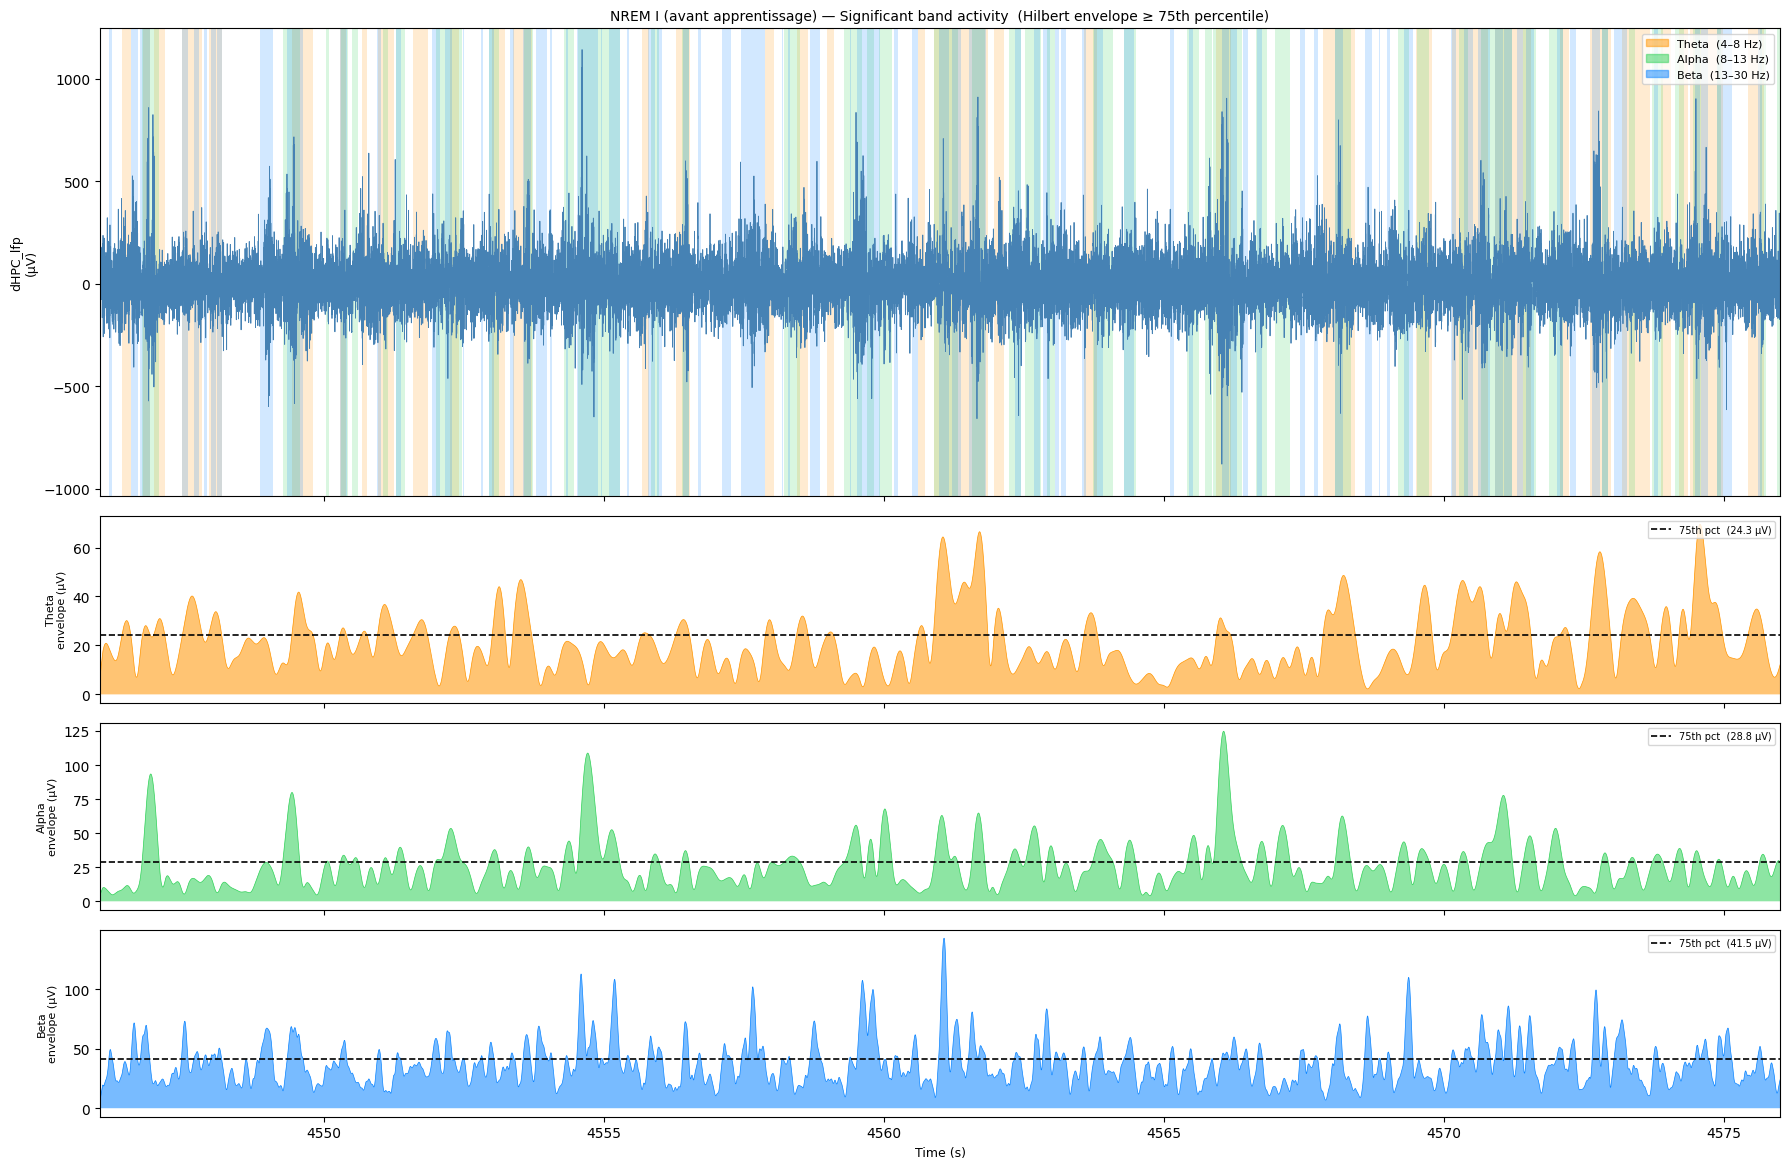

In [38]:
# --- NREM I  (avant apprentissage) — epoch idx=5, fenêtre de 30 s ---
epoch_pre  = nrem1[nrem1["epoch_idx"] == 5].iloc[0]

fig_pre = plot_band_activity(
    epoch_row=epoch_pre,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_pre["t_start"], epoch_pre["t_start"] + 30),
    title_prefix="NREM I (avant apprentissage)",
)
plt.show()

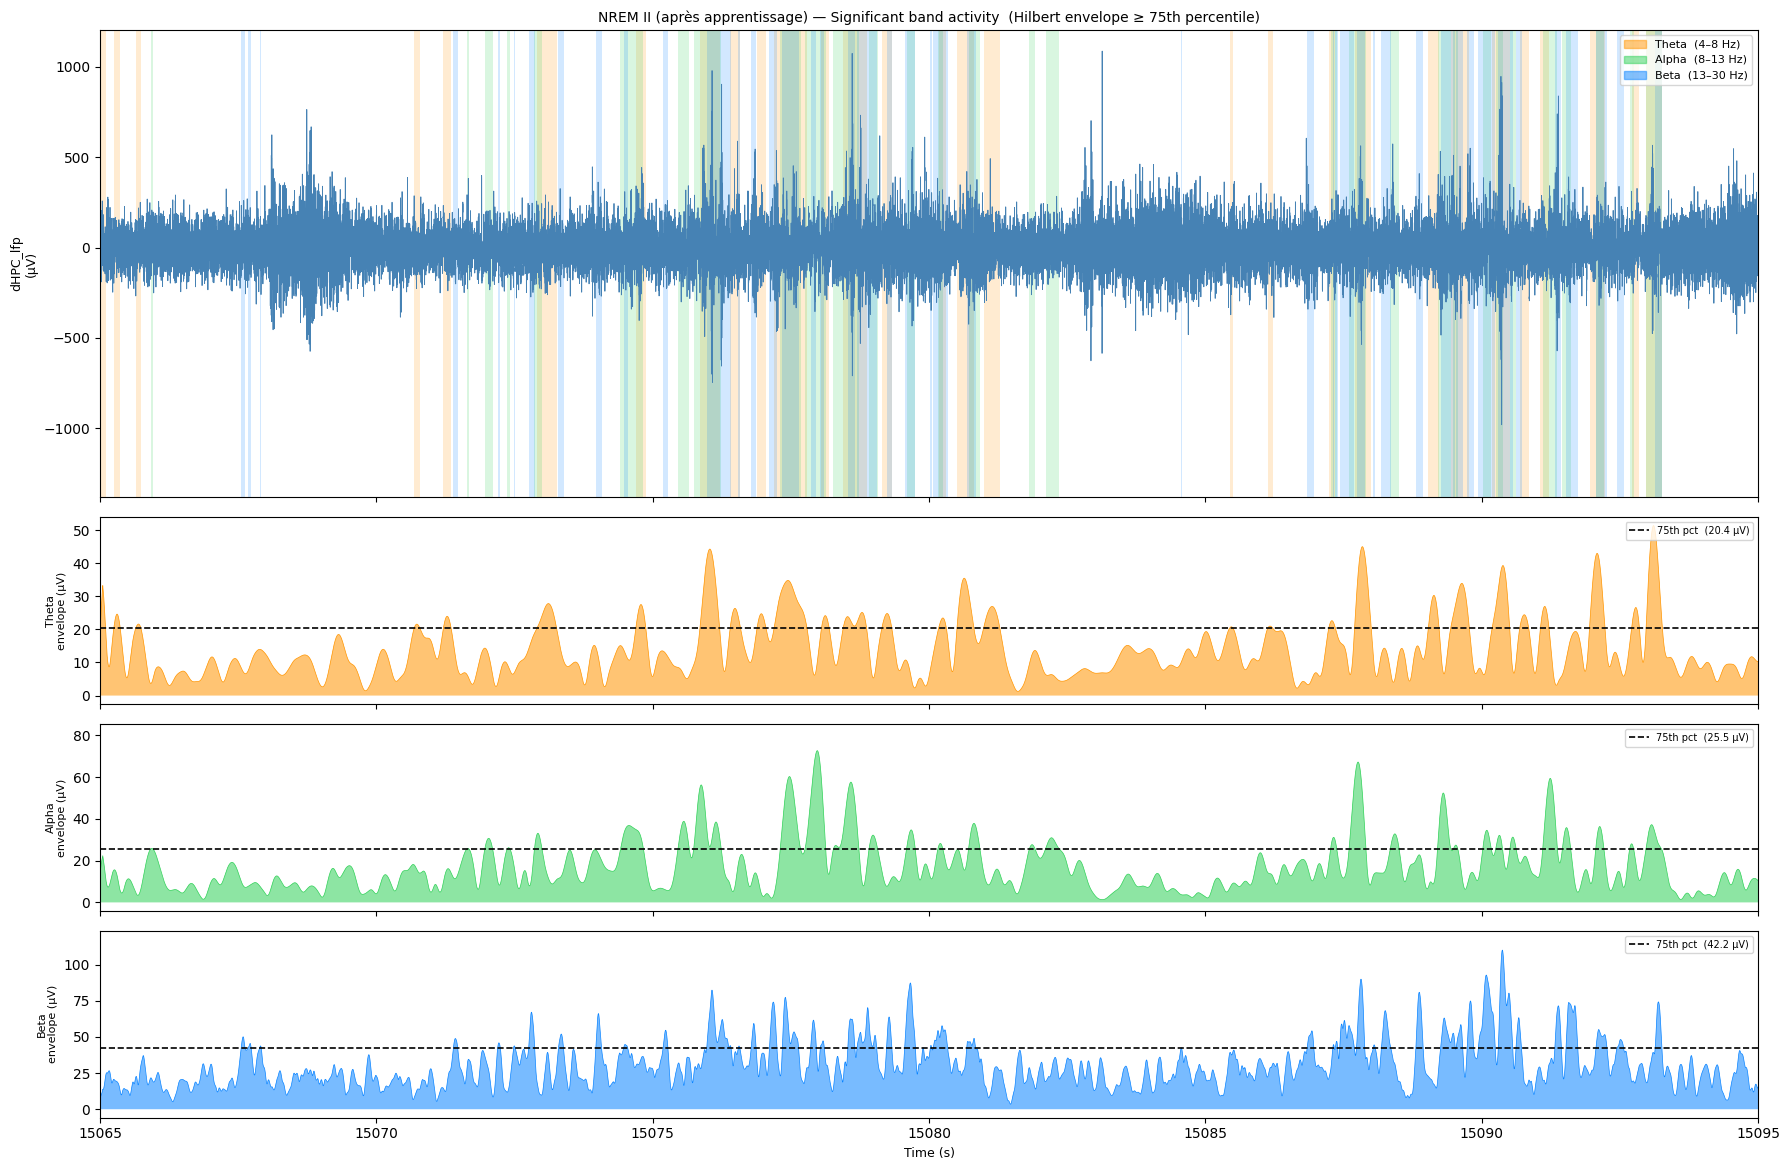

In [39]:
# --- NREM II (après apprentissage) — epoch idx=1, fenêtre de 30 s ---
epoch_post = nrem2[nrem2["epoch_idx"] == 1].iloc[0]

fig_post = plot_band_activity(
    epoch_row=epoch_post,
    channel="dHPC_lfp",
    fs=FS,
    threshold_percentile=75,
    xlim=(epoch_post["t_start"], epoch_post["t_start"] + 30),
    title_prefix="NREM II (après apprentissage)",
)
plt.show()

## 3. Comparaison PSD moyenne — NREM I vs NREM II

On calcule la densité spectrale de puissance (méthode de Welch) de **chaque
epoch**, puis on trace la moyenne ± écart-type pour chaque condition.
La bande alpha (8–13 Hz) est mise en évidence.

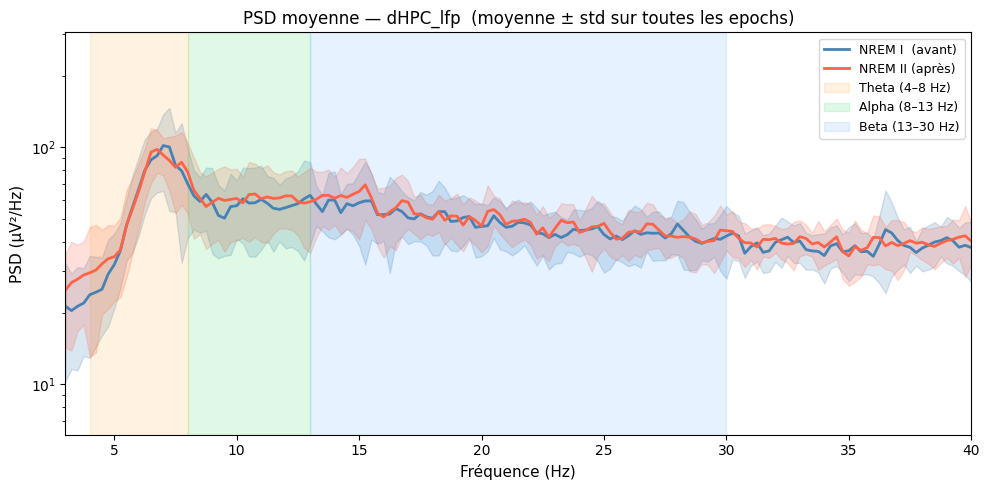

In [40]:
CHANNEL = "dHPC_lfp"

def epoch_psds(epoch_df, channel=CHANNEL, fs=FS):
    """Compute Welch PSD for every epoch row; return (freqs, psds list)."""
    psds = []
    freqs_ref = None
    for _, row in epoch_df.iterrows():
        lfp = np.asarray(row[channel])
        f, psd = welch(lfp, fs=fs, nperseg=4 * fs, noverlap=2 * fs)
        psds.append(psd)
        if freqs_ref is None:
            freqs_ref = f
    return freqs_ref, np.array(psds)


freqs, psds_pre  = epoch_psds(nrem1)
freqs, psds_post = epoch_psds(nrem2)

FMIN, FMAX = 3, 40
freq_mask = (freqs >= FMIN) & (freqs <= FMAX)

fig, ax = plt.subplots(figsize=(10, 5))

for label, psds, color in [
    ("NREM I  (avant)", psds_pre,  "steelblue"),
    ("NREM II (après)", psds_post, "tomato"),
]:
    mean_psd = psds.mean(axis=0)
    std_psd  = psds.std(axis=0)
    ax.semilogy(freqs[freq_mask], mean_psd[freq_mask], color=color, lw=2, label=label)
    ax.fill_between(
        freqs[freq_mask],
        np.maximum(mean_psd[freq_mask] - std_psd[freq_mask], 1e-9),
        mean_psd[freq_mask] + std_psd[freq_mask],
        alpha=0.2, color=color,
    )

# Highlight bands (clipped to visible range)
ax.axvspan(max(FREQ_BANDS["theta"][0], FMIN), min(FREQ_BANDS["theta"][1], FMAX),
           color="#FF9500", alpha=0.12, label="Theta (4–8 Hz)")
ax.axvspan(*FREQ_BANDS["alpha"], color="#30D158", alpha=0.15, label="Alpha (8–13 Hz)")
ax.axvspan(*FREQ_BANDS["beta"],  color="#0A84FF", alpha=0.10, label="Beta (13–30 Hz)")

# y-limits from actual data in [FMIN, FMAX]
all_means = np.concatenate([psds_pre[:, freq_mask].mean(axis=0),
                             psds_post[:, freq_mask].mean(axis=0)])
ax.set_ylim(all_means.min() * 0.3, all_means.max() * 3)

ax.set_xlim(FMIN, FMAX)
ax.set_xlabel("Fréquence (Hz)", fontsize=11)
ax.set_ylabel("PSD (µV²/Hz)", fontsize=11)
ax.set_title(f"PSD moyenne — {CHANNEL}  (moyenne ± std sur toutes les epochs)", fontsize=12)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


## 4. Puissance alpha moyenne par epoch

Pour chaque epoch on calcule la **puissance alpha relative** :
$$P_{\alpha, rel} = \frac{\int_{8}^{13} PSD(f)\, df}{\int_{0}^{100} PSD(f)\, df}$$

Cela normalise par la puissance totale et permet de comparer des epochs
de durées différentes.

In [41]:
def band_relative_power(psd, freqs, f_low, f_high, f_total_max=100):
    """Fraction of total power in [f_low, f_high]."""
    band_mask  = (freqs >= f_low)  & (freqs <= f_high)
    total_mask = (freqs >= 0.5)    & (freqs <= f_total_max)
    return psd[band_mask].sum() / psd[total_mask].sum()


alpha_lo, alpha_hi = FREQ_BANDS["alpha"]

alpha_pre  = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_pre])
alpha_post = np.array([band_relative_power(p, freqs, alpha_lo, alpha_hi) for p in psds_post])

print(f"Alpha relative power — NREM I  : {alpha_pre.mean():.4f} ± {alpha_pre.std():.4f}  (n={len(alpha_pre)})")
print(f"Alpha relative power — NREM II : {alpha_post.mean():.4f} ± {alpha_post.std():.4f}  (n={len(alpha_post)})")

Alpha relative power — NREM I  : 0.0678 ± 0.0138  (n=20)
Alpha relative power — NREM II : 0.0657 ± 0.0143  (n=17)


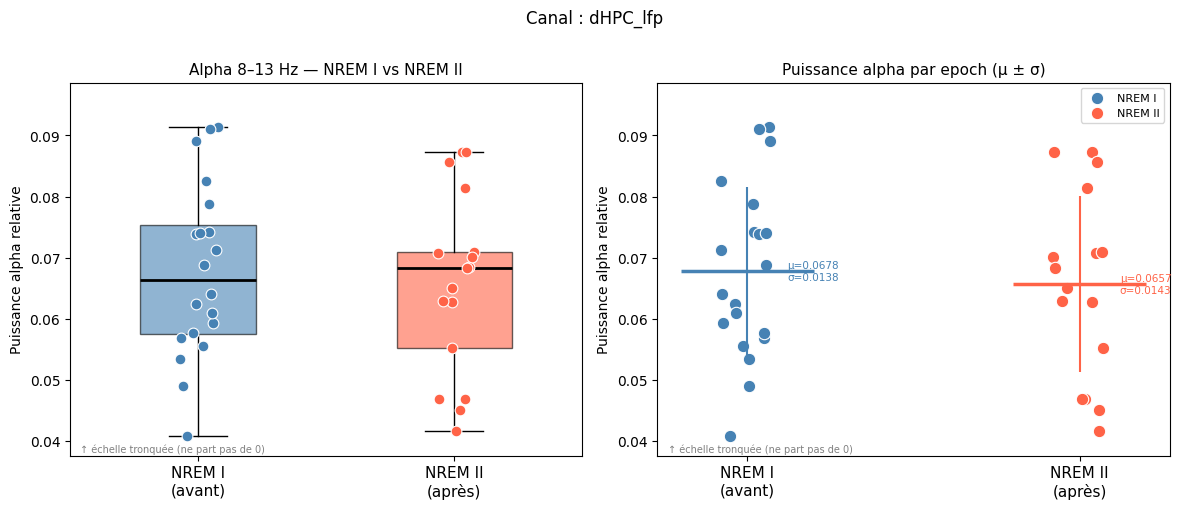

In [42]:
all_vals = np.concatenate([alpha_pre, alpha_post])
y_min = all_vals.min() * 0.92
y_max = all_vals.max() * 1.08

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors_box = ["steelblue", "tomato"]

# --- Left: boxplot + individual points, y-axis clipped to data range ---
ax = axes[0]
bp = ax.boxplot(
    [alpha_pre, alpha_post],
    patch_artist=True,
    widths=0.45,
    medianprops=dict(color="black", lw=2),
    showfliers=False,   # outliers already shown by scatter below
)
for patch, color in zip(bp["boxes"], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

for i, (vals, color) in enumerate(zip([alpha_pre, alpha_post], colors_box), start=1):
    jitter = np.random.default_rng(42).uniform(-0.08, 0.08, size=len(vals))
    ax.scatter(i + jitter, vals, color=color, zorder=3, s=60,
               edgecolors="white", lw=0.8)

ax.set_ylim(y_min, y_max)
ax.set_xticks([1, 2])
ax.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=11)
ax.set_ylabel("Puissance alpha relative", fontsize=10)
ax.set_title("Alpha 8–13 Hz — NREM I vs NREM II", fontsize=11)
# Mark that axis doesn't start at 0
ax.annotate("↑ échelle tronquée (ne part pas de 0)", xy=(0.02, 0.01),
            xycoords="axes fraction", fontsize=7, color="grey")

# --- Right: strip plot (points + mean line) — évite le problème du bar à 0 ---
ax2 = axes[1]
x_pre  = np.zeros(len(alpha_pre))
x_post = np.ones(len(alpha_post))

for x_group, vals, color, label in [
    (x_pre,  alpha_pre,  "steelblue", "NREM I"),
    (x_post, alpha_post, "tomato",    "NREM II"),
]:
    jitter = np.random.default_rng(0).uniform(-0.08, 0.08, size=len(vals))
    ax2.scatter(x_group + jitter, vals, color=color, s=80,
                edgecolors="white", lw=0.8, zorder=3, label=label)
    # Mean ± std bar
    mean, std = vals.mean(), vals.std()
    x_center  = x_group[0]
    ax2.hlines(mean, x_center - 0.2, x_center + 0.2,
               colors=color, lw=2.5, zorder=4)
    ax2.vlines(x_center, mean - std, mean + std,
               colors=color, lw=1.5, zorder=4)
    ax2.annotate(f"μ={mean:.4f}\nσ={std:.4f}",
                 xy=(x_center + 0.12, mean),
                 fontsize=7.5, color=color, va="center")

ax2.set_ylim(y_min, y_max)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=11)
ax2.set_ylabel("Puissance alpha relative", fontsize=10)
ax2.set_title("Puissance alpha par epoch (μ ± σ)", fontsize=11)
ax2.legend(fontsize=8, loc="upper right")
ax2.annotate("↑ échelle tronquée (ne part pas de 0)", xy=(0.02, 0.01),
             xycoords="axes fraction", fontsize=7, color="grey")

plt.suptitle(f"Canal : {CHANNEL}", fontsize=12, y=1.01)
plt.tight_layout()
plt.show()


## 4b. Contrôle : activité neuronale générale ou effet spécifique à l'alpha ?

Si la puissance augmente dans **toutes** les bandes de façon similaire, c'est probablement une hausse d'activité globale et non un effet spécifique à l'alpha.

On vérifie en deux temps :
1. **Puissance broadband absolue** (3–40 Hz) — si elle augmente entre NREM I et NREM II, les neurones sont plus actifs en général.
2. **Puissance relative de chaque bande** (theta, alpha, beta) — si alpha seule ressort, l'effet est bien spécifique.

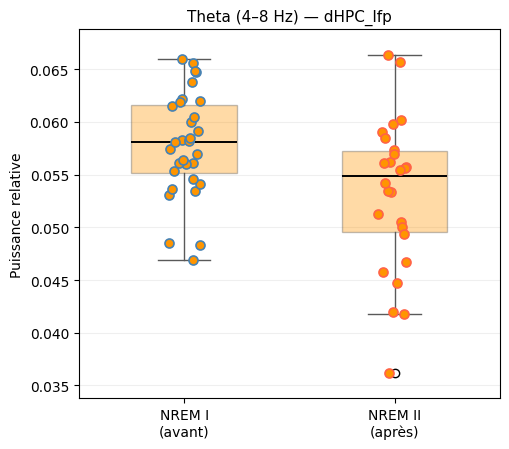

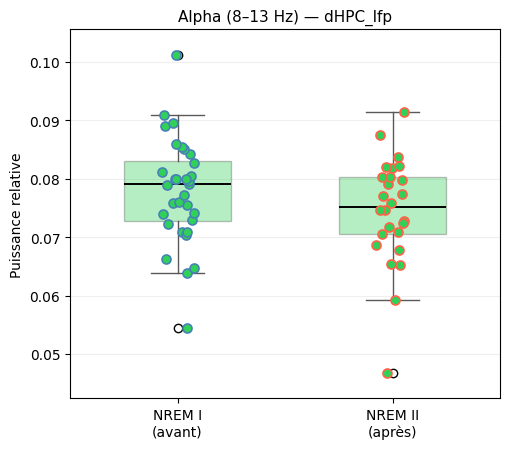

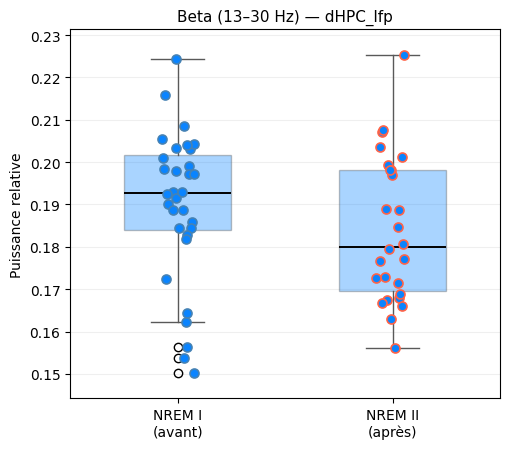

In [43]:
# ── Boxplots séparés par bande, sans axe Y cassé ──────────────────────────────
# Fallbacks pour éviter les erreurs "undefined variable"
if "BANDS_ALL" not in globals():
    BANDS_ALL = {k: FREQ_BANDS[k] for k in ["theta", "alpha", "beta"]}

if ("rel_pre" not in globals()) or ("rel_post" not in globals()):
    rel_pre = {
        b: np.array([band_relative_power(p, freqs, *BANDS_ALL[b]) for p in psds_pre])
        for b in BANDS_ALL
    }
    rel_post = {
        b: np.array([band_relative_power(p, freqs, *BANDS_ALL[b]) for p in psds_post])
        for b in BANDS_ALL
    }

band_names = list(BANDS_ALL.keys())  # ['theta', 'alpha', 'beta']
band_colors = {"theta": "#FF9500", "alpha": "#30D158", "beta": "#0A84FF"}

for band in band_names:
    pre_vals = rel_pre[band]
    post_vals = rel_post[band]
    all_vals = np.r_[pre_vals, post_vals]

    # Limites Y "normales" avec petite marge
    y_min, y_max = all_vals.min(), all_vals.max()
    pad = 0.08 * (y_max - y_min + 1e-12)

    fig, ax = plt.subplots(figsize=(5.2, 4.6))

    bp = ax.boxplot(
        [pre_vals, post_vals],
        positions=[0, 1],
        widths=0.5,
        patch_artist=True,
        showfliers=True,
        medianprops=dict(color="black", lw=1.4),
        whiskerprops=dict(color="0.35"),
        capprops=dict(color="0.35"),
        boxprops=dict(edgecolor="0.3"),
    )
    for patch in bp["boxes"]:
        patch.set_facecolor(band_colors[band])
        patch.set_alpha(0.35)

    rng = np.random.default_rng(42)
    for x0, vals, edge in [(0, pre_vals, "steelblue"), (1, post_vals, "tomato")]:
        jitter = rng.uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(
            x0 + jitter, vals, s=42,
            color=band_colors[band], edgecolors=edge, linewidths=1.2, zorder=3
        )

    ax.set_ylim(y_min - pad, y_max + pad)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=10)
    ax.set_ylabel("Puissance relative")
    ax.set_title(f"{band.capitalize()} ({BANDS_ALL[band][0]}–{BANDS_ALL[band][1]} Hz) — {CHANNEL}", fontsize=11)
    ax.grid(axis="y", alpha=0.2)

    plt.tight_layout()
    plt.show()


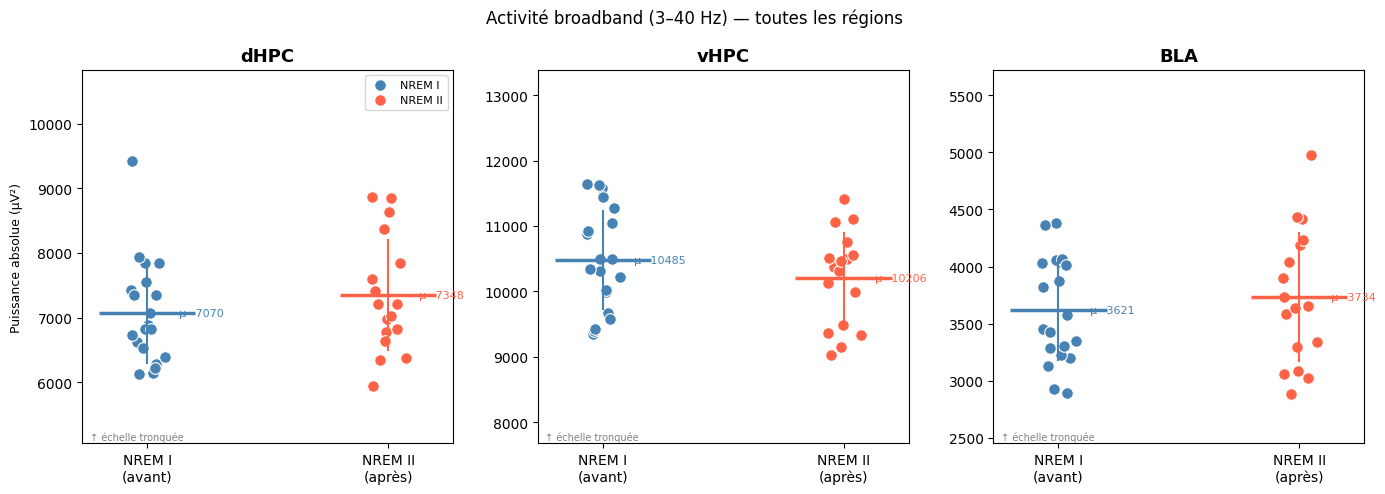

In [44]:
channels      = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
channel_labels = ["dHPC",    "vHPC",     "BLA"]
BROADBAND = (3, 40)  # Hz — pour calculer la puissance totale dans ce range

broad_by_ch = {}
for ch in channels:
    _, psds_pre_ch  = epoch_psds(nrem1, channel=ch)
    _, psds_post_ch = epoch_psds(nrem2, channel=ch)
    broad_mask = (freqs >= BROADBAND[0]) & (freqs <= BROADBAND[1])
    broad_by_ch[ch] = {
        "pre":  psds_pre_ch[:,  broad_mask].sum(axis=1),
        "post": psds_post_ch[:, broad_mask].sum(axis=1),
    }

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, ch, label in zip(axes, channels, channel_labels):
    pre  = broad_by_ch[ch]["pre"]
    post = broad_by_ch[ch]["post"]

    for x_pos, vals, color, cond in [
        (0, pre,  "steelblue", "NREM I"),
        (1, post, "tomato",    "NREM II"),
    ]:
        jitter = np.random.default_rng(3).uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(x_pos + jitter, vals, color=color, s=70,
                   edgecolors="white", lw=0.8, zorder=3, label=cond)
        mean, std = vals.mean(), vals.std()
        ax.hlines(mean, x_pos - 0.2, x_pos + 0.2, colors=color, lw=2.5, zorder=4)
        ax.vlines(x_pos, mean - std,  mean + std,  colors=color, lw=1.5, zorder=4)
        ax.annotate(f"μ={mean:.0f}", xy=(x_pos + 0.13, mean),
                    fontsize=8, color=color, va="center")

    all_vals = np.concatenate([pre, post])
    ax.set_ylim(all_vals.min() * 0.85, all_vals.max() * 1.15)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=10)
    ax.set_title(label, fontsize=13, fontweight="bold")
    ax.set_ylabel("Puissance absolue (µV²)" if ch == channels[0] else "", fontsize=9)
    ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                fontsize=7, color="grey")
    if ch == channels[0]:
        ax.legend(fontsize=8)

plt.suptitle(f"Activité broadband ({BROADBAND[0]}–{BROADBAND[1]} Hz) — toutes les régions",
             fontsize=12)
plt.tight_layout()
plt.show()


## 5. Comparaison multi-canaux

Est-ce que le changement est spécifique à une région cérébrale ?
On répète le calcul pour dHPC, vHPC et BLA.

In [45]:
channels = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
channel_labels = ["dHPC", "vHPC", "BLA"]

results = {}  # {channel: {"pre": array, "post": array}}

for ch in channels:
    f, psds_pre_ch  = epoch_psds(nrem1, channel=ch)
    f, psds_post_ch = epoch_psds(nrem2, channel=ch)
    results[ch] = {
        "pre":  np.array([band_relative_power(p, f, alpha_lo, alpha_hi) for p in psds_pre_ch]),
        "post": np.array([band_relative_power(p, f, alpha_lo, alpha_hi) for p in psds_post_ch]),
    }

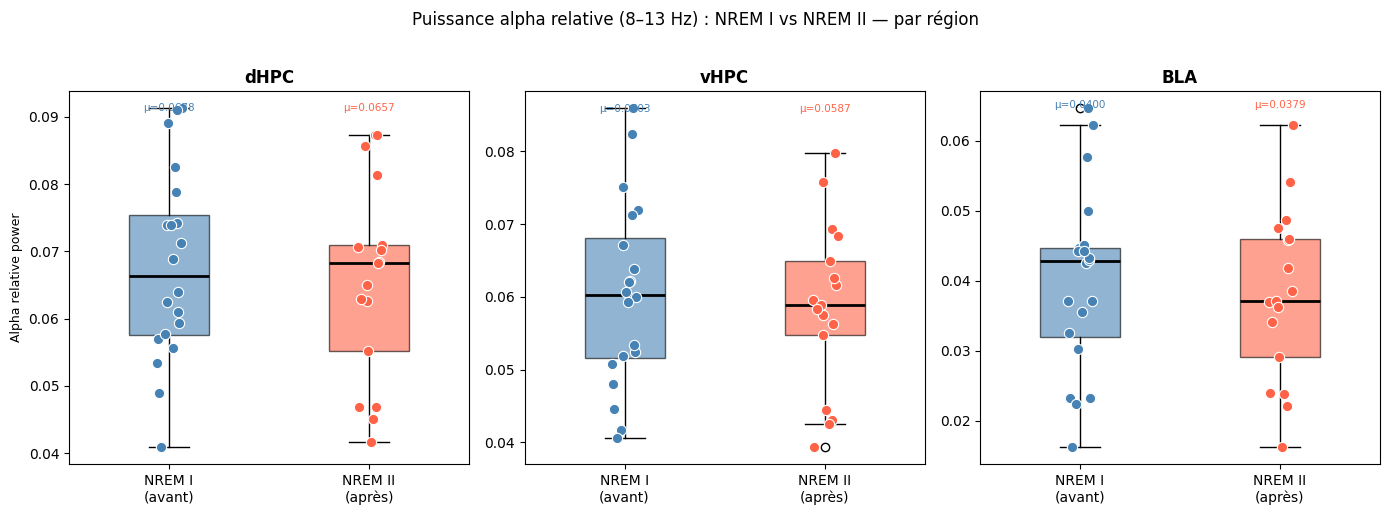

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

for ax, ch, label in zip(axes, channels, channel_labels):
    pre  = results[ch]["pre"]
    post = results[ch]["post"]

    bp = ax.boxplot(
        [pre, post],
        patch_artist=True,
        widths=0.4,
        medianprops=dict(color="black", lw=2),
    )
    for patch, color in zip(bp["boxes"], ["steelblue", "tomato"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    for i, (vals, color) in enumerate(zip([pre, post], ["steelblue", "tomato"]), start=1):
        jitter = np.random.default_rng(42).uniform(-0.07, 0.07, size=len(vals))
        ax.scatter(i + jitter, vals, color=color, zorder=3, s=55,
                   edgecolors="white", lw=0.8)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["NREM I\n(avant)", "NREM II\n(après)"], fontsize=10)
    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_ylabel("Alpha relative power" if ch == channels[0] else "", fontsize=9)

    # Annotate means
    for x_pos, vals, color in [(1, pre, "steelblue"), (2, post, "tomato")]:
        ax.text(x_pos, ax.get_ylim()[1] * 0.98,
                f"μ={vals.mean():.4f}",
                ha="center", va="top", fontsize=7.5, color=color)

plt.suptitle("Puissance alpha relative (8–13 Hz) : NREM I vs NREM II — par région",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 6. Évolution temporelle de la puissance alpha au sein d'une epoch

On utilise `detect_significant_band_epochs` pour obtenir l'enveloppe
instantanée et on compare la dynamique intra-epoch entre NREM I et NREM II.

On prend l'epoch la plus longue de chaque condition et on re-normalise
le temps entre 0 et 1 pour faciliter la comparaison.

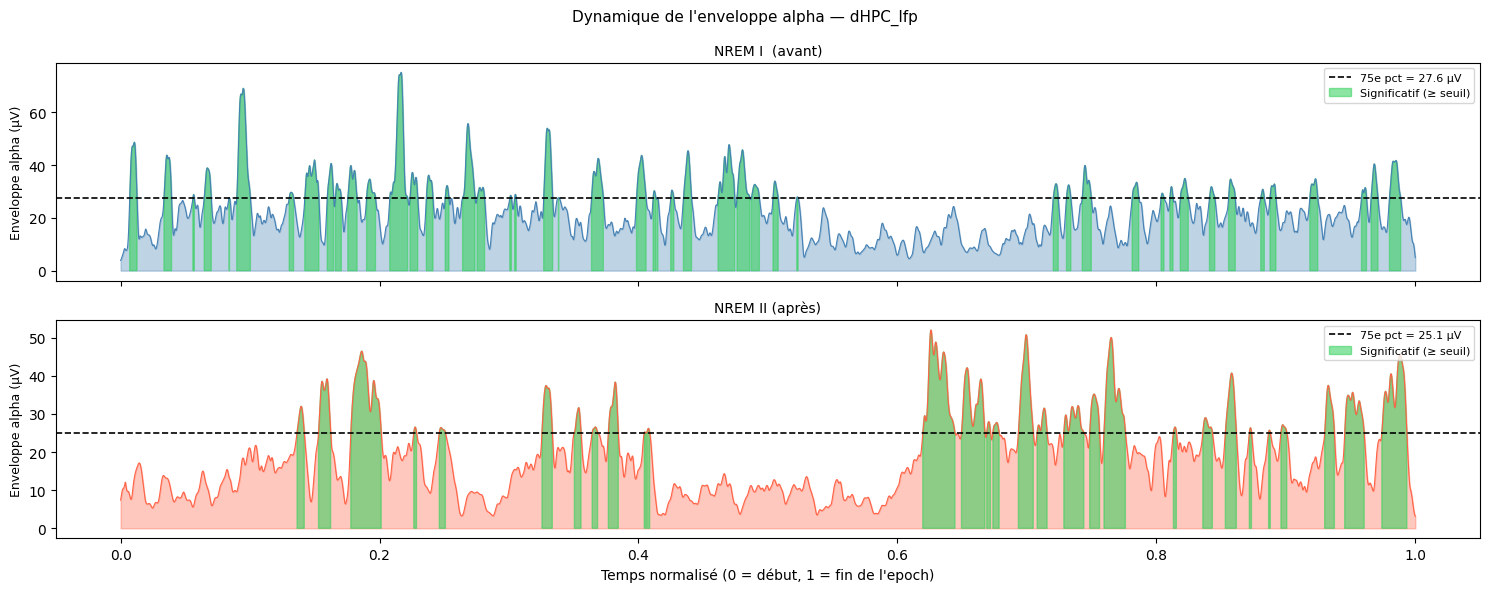

Fraction de temps au-dessus du seuil alpha :
  NREM I  : 25.0 %
  NREM II : 25.0 %


In [47]:
# Pick a representative epoch from each condition (similar duration ~120–140 s)
ep_pre_ex  = nrem1[nrem1["epoch_idx"] == 5].iloc[0]   # 139 s
ep_post_ex = nrem2[nrem2["epoch_idx"] == 1].iloc[0]   # 120 s

alpha_bands = {"alpha": FREQ_BANDS["alpha"]}

def get_alpha_envelope(epoch_row, channel=CHANNEL, fs=FS):
    lfp = np.asarray(epoch_row[channel])
    res = detect_significant_band_epochs(
        lfp, fs,
        t_start=float(epoch_row["t_start"]),
        smooth_sec=0.5,          # smoother trace for visualisation
        threshold_percentile=75,
        bands=alpha_bands,
    )
    times    = res["times"]
    envelope = res["envelopes"]["alpha"]
    thr      = res["thresholds"]["alpha"]
    sig      = res["significant"]["alpha"]
    # Normalise time to [0, 1]
    t_norm = (times - times[0]) / (times[-1] - times[0])
    return t_norm, envelope, thr, sig


t_pre,  env_pre,  thr_pre,  sig_pre  = get_alpha_envelope(ep_pre_ex)
t_post, env_post, thr_post, sig_post = get_alpha_envelope(ep_post_ex)

fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

for ax, t, env, thr, sig, label, color in [
    (axes[0], t_pre,  env_pre,  thr_pre,  sig_pre,  "NREM I  (avant)", "steelblue"),
    (axes[1], t_post, env_post, thr_post, sig_post, "NREM II (après)", "tomato"),
]:
    # Plot envelope
    ax.fill_between(t, env, alpha=0.35, color=color)
    ax.plot(t, env, lw=0.8, color=color)
    # Threshold line
    ax.axhline(thr, color="black", lw=1.2, ls="--",
               label=f"75e pct = {thr:.1f} µV")
    # Shade significant regions
    ax.fill_between(t, 0, env, where=sig, alpha=0.55,
                    color="#30D158", label="Significatif (≥ seuil)")
    ax.set_ylabel("Enveloppe alpha (µV)", fontsize=9)
    ax.set_title(label, fontsize=10)
    ax.legend(fontsize=8, loc="upper right")

axes[1].set_xlabel("Temps normalisé (0 = début, 1 = fin de l'epoch)", fontsize=10)
plt.suptitle(f"Dynamique de l'enveloppe alpha — {CHANNEL}", fontsize=11)
plt.tight_layout()
plt.show()

# Fraction of time above threshold
frac_pre  = sig_pre.mean() * 100
frac_post = sig_post.mean() * 100
print(f"Fraction de temps au-dessus du seuil alpha :")
print(f"  NREM I  : {frac_pre:.1f} %")
print(f"  NREM II : {frac_post:.1f} %")

---
## Résumé

| | NREM I (avant) | NREM II (après) |
|---|---|---|
| Epochs | 8 | 5 |
| Puissance alpha relative dHPC | voir cellule 4 | voir cellule 4 |
| Fraction de temps alpha significatif | voir cellule 6 | voir cellule 6 |

**Lecture des résultats**
- Si NREM II > NREM I → l'apprentissage a augmenté l'activité alpha pendant le sommeil.
- Comparez les trois régions (dHPC, vHPC, BLA) : un effet localisé dans le dHPC ou le vHPC serait biologiquement cohérent avec la consolidation mnésique hippocampique.
- Explorez aussi les bandes theta et beta avec la même approche !

Pour aller plus loin : comparez la condition **neutral** (`lfp_data.pkl`) avec la condition **aversive** (`lfp_epochs_with_spikes_by_region_aversive.pkl`).